In [1]:
!pip install sympy==1.5.1
import sympy
print(sympy.__version__)

     |████████████████████████████████| 5.6MB 37.0MB/s 
  Found existing installation: sympy 1.1.1
    Uninstalling sympy-1.1.1:
      Successfully uninstalled sympy-1.1.1
1.5.1


In [0]:
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
x, hbar, w = symbols("x, hbar, w")

In [0]:
class SHO:
    # Class SHO
    # This class recieve a 1-dim'l function as a string(need not be normalized)
    # and analyze the function in the SHO basis
    # Need Update : functions for time-dependent problems

    # Private methods
    def __init__(self, psi):
        # primitive store the ground state of SHO
        # psi store the wave function to analyze in the energy basis of SHO
        self.__primitive = pi**(-1/4) * exp(-x**2/2)
        self.psi = self.__Normalize(sympify(psi))

    def __Normalize(self, expr):
        # 1 = A^*A<psi|psi>
        # Get A and updaate psi
        norm = integrate(expr*expr, (x, -oo, oo))
        expr = expr / sqrt(norm)
        return expr.simplify()

    def __Pos(self, expr):
        # X(psi) = x*psi
        temp = x * expr
        return temp.simplify()

    def __Mom(self, expr):
        # P(psi) = -id(psi)/dx
        temp = -I * diff(expr)
        return temp.simplify()

    def __Raising(self, basis):
        # a^+ = (-ip + x)/sqrt(2)
        temp1 = -I * self.__Mom(basis)
        temp2 = self.__Pos(basis)
        temp = (1/sqrt(2)) * (temp1 + temp2)
        return temp.simplify()

    def __Lowering(self, basis):
        # a = (ip + x)/sqrt(2)
        temp1 = I * self.__Mom(basis)
        temp2 = self.__Pos(basis)
        temp = (1/sqrt(2)) * (temp1 + temp2)
        return temp.simplify()

    def __Hamiltonian_ladder(self, expr):
        # H = hbar*w(a^+a + 1/2)
        temp1 = self.__Lowering(basis)
        temp1 = self.__Raising(temp1)
        temp1 *= hbar * w
        temp2 = hbar*w*(1/2)*basis
        temp = temp1 + temp2
        return temp.simplify()

    def __Hamiltonian_xp(self, expr):
        # H = (hbar*w /2)*(p^2 + x^2)
        temp1 = self.__Mom(self.__Mom(expr))
        temp2 = self.__Pos(self.__Pos(expr))
        temp = (hbar*w/2)*(temp1 + temp2)
        return temp.simplify()

    def __InnerProduct(self, expr1, expr2):
        # <f_1|f_2>
        expr1 = conjugate(expr1)
        temp = integrate(expr1*expr2, (x, -oo, oo))
        return temp.simplify()

    # Public methods
    def Raise(self, basis, n):
        # psi_n+1 = a^+psi_n / sqrt(n+1)
        temp = self.__Raising(basis)
        temp /= sqrt(n+1)
        return temp.simplify()

    def Lower(self, basis, n):
        # psi_n-1 = a psi_n / sqrt(n)
        temp = self.__Lowering(basis)
        temp /= sqrt(n)
        return temp.simplify()

    def GetBasis(self, n):
        # psi_n = (a^+)^n psi_0 / sqrt(n!)
        temp = self.__primitive
        for i in range(n):
            temp = self.Raise(temp, i)
        return temp.simplify()

    def GetNumber(self, basis):
        # N psi_n = n psi_n
        # return n
        temp = self.__Lowering(basis)
        temp = self.__Raising(temp)
        return temp.simplify() / basis

    def GetEnergy(self, basis):
        # H psi_n = (n+1/2)*hbar*w
        # return E_n = (n+1/2)*habr*w
        temp = self.__Hamiltonian_xp(basis)
        temp /= basis
        return temp.simplify()

    def CheckOrtho(self, n, m):
        # <n|m> = delta_{nm}
        psi_n = self.GetBasis(n)
        psi_m = self.GetBasis(m)
        result = self.__InnerProduct(psi_n, psi_m)
        return result.simplify()

    def GetCoeff(self, n):
        # c_n = <psi_n|psi>
        psi_n = self.GetBasis(n)
        expr = self.psi
        coeff = self.__InnerProduct(psi_n, expr)
        return coeff.simplify()

    def GetProb(self, n):
        # P(psi->psi_n) = |c_n|^2
        expr = self.psi
        coeff = self.GetCoeff(n, expr)
        prob = conjugate(coeff)*coeff
        return prob.simplify()

    def GetExpectEnergy(self):
        # E = <H> = <psi|H|psi>
        expr = self.psi
        temp = self.__Hamiltonian_xp(expr)
        expect = self.__InnerProduct(expr, temp)
        return expect.simplify()

    def GetClassicalProb(self, n):
        # Get the probability of the particle
        # to be found in the classical region
        # i.e. E_n > V(x) 
        # (n+1/2)*hbar*w > hbar*w*x^2/2
        psi_n = self.GetBasis(n)
        b = sqrt(2*n + 1)
        prob = integrate(conjugate(psi_n)*psi_n, (x, -b, b))
        prob = prob.subs(pi, 3.14)
        prob = prob.subs(E, 2.71)
        prob = float(prob.evalf())
        return prob
    
    def GetNonClassicalProb(self, n):
        # Get the probability of the particle
        # to be found in the nonclassical region
        # i.e. E_n < V(x) 
        # (n+1/2)*hbar*w < hbar*w*x^2/2
        return 1 - self.GetClassicalProb(n)

    # Plotting tools
    def PlotBasis(self, n, xrange, marker, label):
        # Plot the basis functions for the SHO
        psi_n = self.GetBasis(n)
        X = np.arange(-xrange, xrange, 0.01)
        Y = []
        for i in range(X.size):
            Y.append(psi_n.subs(x, X[i]))
        Y = np.array(Y)
        plt.plot(X, Y, marker, label = label)
        plt.xlim(-xrange, xrange)
        plt.xlabel("x")
        plt.ylim(-1, 1)
        plt.ylabel("psi")
        plt.title("Basis Functions")
        plt.grid(True)
        plt.legend(loc = 0)

In [0]:
# problem 2.41 (2nd edition)
m = SHO("((1 - 2*x)**2) * exp(-x**2/2)")

In [5]:
m.psi.simplify()

(4*x**2 - 4*x + 1)*exp(-x**2/2)/(5*pi**(1/4))

$\displaystyle \frac{\left(4 x^{2} - 4 x + 1\right) e^{- \frac{x^{2}}{2}}}{5 \sqrt[4]{\pi}}$

In [6]:
m.GetExpectEnergy()

73*hbar*w/50

$\displaystyle \frac{73 \hbar w}{50}$

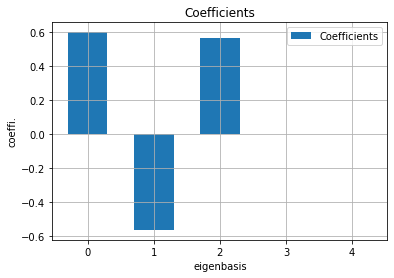

[3/5, -2*sqrt(2)/5, 2*sqrt(2)/5, 0, 0]


In [7]:
lst_co = []
for i in range(5):
    lst_co.append(m.GetCoeff(i))

X = np.arange(len(lst_co))
Y = np.array(lst_co)
plt.bar(X, Y, width=0.6, label="Coefficients")
plt.xlabel("eigenbasis")
plt.ylabel("coeffi.")
plt.title("Coefficients")
plt.legend(loc=0)
plt.grid(True)
plt.show()

print(lst_co)

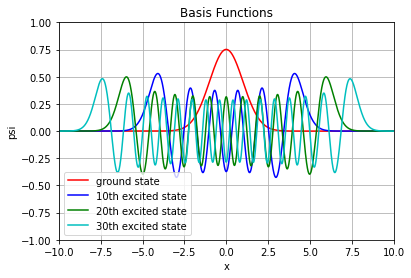

In [8]:
m.PlotBasis(0, 10, "r-", "ground state")
m.PlotBasis(10, 10, "b-", "10th excited state")
m.PlotBasis(20, 10, "g-", "20th excited state")
m.PlotBasis(30, 10, "c-", "30th excited state")

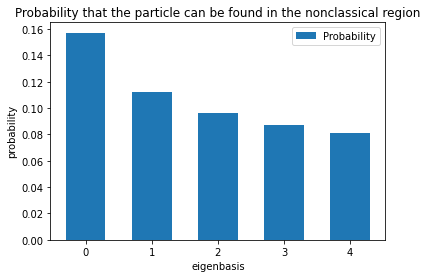

In [9]:
lst = []
for i in range(5):
    p = m.GetNonClassicalProb(i)
    lst.append(p)

Y = np.array(lst)
X = np.arange(Y.size)
plt.title("Probability that the particle can be found in the nonclassical region")
plt.xlabel("eigenbasis")
plt.ylabel("probability")
plt.bar(X, Y, width=0.6, label='Probability')
plt.legend(loc=0)
plt.show()    